In [1]:
%matplotlib inline
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import json
import matplotlib.pyplot as plt
from scipy.stats import logistic
from scipy.special import softmax

from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.engine import InputSpec
from keras.optimizers import RMSprop, Adam
from keras.models import Model
from keras.utils import to_categorical
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import cifar10

import tensorflow as tf

from pixelcnn_helpers import pixelcnn_loss, sigmoid, compute_pvals, compute_mixture, PixelConv2D

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [71]:
#img_rows, img_cols, img_chns = 32, 32, 3
img_rows, img_cols, img_chns = 2, 2, 3
original_img_size = (img_rows, img_cols, img_chns)

# Debug params
sample = 1

# Hyper params
batch_size = int(os.environ.get('BATCH_SIZE', 2))
epochs = int(os.environ.get('EPOCHS', 1000))
activation = os.environ.get('ACTIVATION', 'relu')
learning_rate = float(os.environ.get('LEARNING_RATE', 0.001))
resnet_depth = int(os.environ.get('RESNET_DEPTH', 2))
mixture_components = int(os.environ.get('MIXTURE_COMPONENTS', 2))

# Load CIFAR10 dataset

In [72]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Shift/scale to [-1, 1] interval
X_train = X_train[:sample, :img_rows, :img_cols, :img_chns]
X_train = (X_train - 127.5) / 127.5

#X_train_out = X_train.reshape((X_train.shape[0], -1))

X_test = (X_test - 127.5) / 127.5
#X_test_out = X_test.reshape((X_test.shape[0], -1))

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

#print(X_train.shape, X_train_out.shape, y_train.shape)
#print(X_test.shape, X_test_out.shape, y_test.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1, 2, 2, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


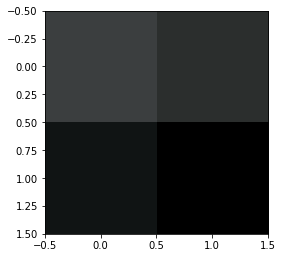

In [73]:
n = min(sample, 10)
figure = np.zeros((img_rows * n, img_cols, img_chns))
for i in range(n):
    orig_img = X_train[i] 
    dy = img_rows * i
    figure[dy:dy + img_rows, :img_cols] = (orig_img * 127.5 + 127.5) / 255.
    
plt.figure(figsize=(n * 4, 10))
plt.imshow(figure)
plt.show()

# Model

In [74]:
if K.image_data_format() == 'channels_last':
    bn_axis = 3
else:
    bn_axis = 1
    
def conv_block(input_tensor, filters, kernel_size, name, is_first=False):
    outs = []
    for t in ['rb', 'gb', 'bb']:
        if is_first:
            t = t[0] + 'a'
        x = PixelConv2D(t, filters, kernel_size, name='res' + name + t, padding='same')(input_tensor)
        #x = Conv2D(filters, kernel_size, name='res' + name + t, padding='same')(input_tensor)
        # x = BatchNormalization(axis=bn_axis, name='bn' + name + t)(x)
        x = Activation('tanh')(x)
        outs.append(x)
        
    return Concatenate()(outs)

def resnet_block(input_tensor, filters, stage, block):
    name_base = str(stage) + block + '_branch'
    filters1, filters2, filters3 = filters
    x = input_tensor
    x = conv_block(x, filters1, (1, 1), name=name_base + '_a-1x1')
    x = conv_block(x, filters2, (3, 3), name=name_base + '_b-3x3')
    x = conv_block(x, filters3, (1, 1), name=name_base + '_c-1x1')
    x = Add()([x, input_tensor])
    
    return x

def final_block(input_tensor, filters, in_filters, name, kernel_size=(1, 1)):
    outs = []
    channel_name = 'rgb'
    for channel in range(img_chns):
        # Only allow things behind it...
        x = Lambda(lambda x: x[:, :, :, :(channel + 1) * in_filters])(input_tensor)
        x = Conv2D(filters, kernel_size, name='final' + name + channel_name[channel], padding='same')(x)
        # x = BatchNormalization(axis=bn_axis, name='bn' + name + t)(x)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)

def build_outputs(input_tensor, final_filters):
    m_outs = []
    invs_outs = []
    weights = []
    for channel in range(img_chns):
        # Only allow things behind it...
        x = Lambda(lambda x: x[:, :, :, :(channel + 1) * final_filters])(input_tensor)
        decoder_out_m = Conv2D(name='x_m' + str(channel), 
                               filters=mixture_components, 
                               kernel_size=1, 
                               strides=1)(x)
        #decoder_out_invs = Conv2D(name='x_s' + str(channel),
        #                           filters=mixture_components,
        #                           kernel_size=1,
        #                           strides=1,
        #                           activation = 'relu')(x)
        decoder_out_invs_ = Conv2D(name='x_s' + str(channel),
                                   filters=mixture_components,
                                   kernel_size=1,
                                   strides=1,
                                   activation='sigmoid')(x)
        decoder_out_invs = Lambda(lambda x: 5. * x + 2.0)(decoder_out_invs_)
        mixture_weights = Conv2D(name='weights' + str(channel),
                                 filters=mixture_components,
                                 kernel_size=1,
                                 strides=1)(x)
        m_outs.append(decoder_out_m)
        invs_outs.append(decoder_out_invs)
        weights.append(mixture_weights)
    
    out_m = Concatenate()(m_outs)       
    out_invs = Concatenate()(invs_outs)       
    out_mixture = Concatenate()(weights)       
    return Concatenate()([out_m, out_invs, out_mixture])

In [75]:
print("Building conv layers...")
main_input = Input(shape=original_img_size, name='main_input')

x = conv_block(main_input, 1024, (7, 7), name='conv1', is_first=True)

#for stage in range(resnet_depth):
#    x = resnet_block(x, [128, 128, 256], stage, 'a')

final_width = 1024
#x = final_block(x, final_width, 256, '1x1_1000_1')
#x = final_block(x, final_width, final_width, '1x1_1000_2')

print("Building output layers...")
outputs = build_outputs(x, final_width)
main_output = outputs

print("Building model...")
model = Model(inputs=main_input, outputs=main_output)
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss=lambda x, y: pixelcnn_loss(x, y, img_rows, img_cols, img_chns, mixture_components))
model.summary()

Building conv layers...
Building output layers...
Building model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 2, 2, 3)      0                                            
__________________________________________________________________________________________________
resconv1ra (PixelConv2D)        (None, 2, 2, 1024)   151552      main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ga (PixelConv2D)        (None, 2, 2, 1024)   151552      main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ba (PixelConv2D)        (None, 2, 2, 1024)   151552      main_input[0][0]                 
_________________________________________

In [76]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=1.0, patience=20)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=0.01 * learning_rate)
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs_2019-04-04/', histogram_freq=1, batch_size=1,
                                          write_grads=True, write_images=True, update_freq='batch')

history = model.fit(
    #X_train, X_train_out,
    X_train, X_train,
    batch_size=batch_size,
    #epochs=epochs,
    epochs=50,
    callbacks=[TQDMNotebookCallback()], #, tensorboard],#, early_stopping, reduce_lr],
    #validation_data=(X_test, X_test_out),
    validation_data=(X_train, X_train),
    verbose=0
)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)


Elapsed:  5.661479473114014


,val_loss,loss
count,50.000000,50.000000
mean,126.013246,142.425798
std,151.991086,184.486416
min,50.340874,51.109390
0%,50.340874,51.109390
25%,56.707595,56.773077
50%,69.527290,70.529720
75%,79.724962,88.443901
95%,480.147334,585.553140
99%,694.681852,813.015598


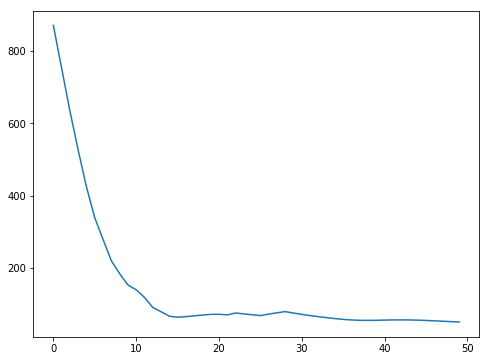

In [77]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df['loss'].plot(figsize=(8, 6))

In [78]:
print(df)

      val_loss        loss
0   752.697266  870.968506
1   634.298462  752.697266
2   525.975525  634.298462
3   424.135101  525.975525
4   339.236511  424.135101
5   279.240295  339.236511
6   220.435455  279.240295
7   184.676544  220.435455
8   153.565796  184.676544
9   140.020401  153.565796
10  119.125351  140.020401
11   91.331467  119.125351
12   79.556236   91.331467
13   67.058670   79.556236
14   64.227089   67.058670
15   65.882751   64.227089
16   67.984268   65.882751
17   70.244797   67.984268
18   72.125916   70.244797
19   72.321404   72.125916
20   70.814644   72.321404
21   75.923203   70.814644
22   73.449448   75.923203
23   71.098289   73.449448
24   68.690689   71.098289
25   72.952240   68.690689
26   76.476585   72.952240
27   79.781204   76.476585
28   75.821732   79.781204
29   72.112938   75.821732
30   68.809784   72.112938
31   65.827202   68.809784
32   63.060097   65.827202
33   60.511009   63.060097
34   58.306629   60.511009
35   56.660927   58.306629
3

In [79]:
lossvals = model.evaluate(X_train, X_train)
print(lossvals)

vals = model.predict(X_train)

1/1 [==============================] - 0s 5ms/step
50.34087371826172


(2, 20, 3)
==== 0 0 0
X_train[0, i, j, k] =  -0.5372549019607843  (59.0)
 m:  [-0.4418291  -0.10670283]
 E[m]:  -0.36888298
 invs:  [3.6220822 4.386565 ]
 weights:  [0.78233254 0.21766743]
 pvals:  61     0.010555
62     0.013697
63     0.017590
64     0.022292
65     0.027780
66     0.033902
67     0.040333
68     0.046554
69     0.051896
70     0.055653
71     0.057257
72     0.056448
73     0.053358
74     0.048469
75     0.042462
76     0.036035
77     0.029764
78     0.024040
79     0.019068
80     0.014908
81     0.011525
110    0.010084
111    0.016481
112    0.024448
113    0.031506
114    0.033983
115    0.030290
116    0.022741
117    0.014968
dtype: float64
 pixel_val:  64
==== 0 0 1
X_train[0, i, j, k] =  -0.5137254901960784  (62.0)
 m:  [-0.19672635 -0.04862855]
 E[m]:  -0.16470397
 invs:  [3.648991 4.455485]
 weights:  [0.7837754 0.2162246]
 pvals:  93     0.012366
94     0.016080
95     0.020649
96     0.026096
97     0.032321
98     0.039046
99     0.045774
100    0.051

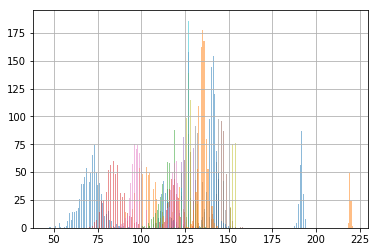

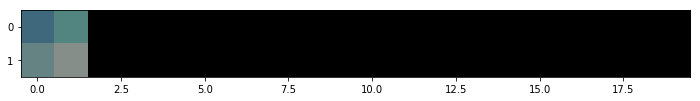

Elapsed:  3.650634527206421


In [80]:
debug = True

def gen_image(model, num_samples=batch_size):
    x_sample = np.zeros((num_samples, img_rows, img_cols, img_chns))
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(img_rows):
        for j in range(img_cols):
            for k in range(img_chns):
                x_out = model.predict(x_sample, num_samples)
                for n in range(num_samples):
                    offset = k * mixture_components
                    x_ms = x_out[n, i, j, offset:offset + mixture_components]
                    offset = mixture_components * img_chns + k * mixture_components
                    x_invs = x_out[n, i, j, offset:offset + mixture_components]
                    offset = 2 * mixture_components * img_chns + k * mixture_components
                    weights = softmax(x_out[n, i, j, offset:offset + mixture_components])
                    pvals = compute_mixture(x_ms, x_invs, weights, mixture_components)
                    pvals /= (np.sum(pvals) + 1e-5)
                    pixel_val = np.argmax(np.random.multinomial(1, pvals))
                    x_sample[n, i, j, k] = pixel_val / 255.
                    if 0 <= i <= 16 and 0 <= j <= 16 and debug:
                        print("====", i, j, k)
                        print("X_train[0, i, j, k] = ", X_train[0, i, j, k], 
                              " (%s)" % (X_train[0, i, j, k] * 127.5 + 127.5))
                        print(" m: ", x_ms)
                        print(" E[m]: ", (x_ms * weights).sum())
                        print(" invs: ", x_invs)
                        print(" weights: ", weights)
                        s = pd.Series(pvals)
                        print(" pvals: ", s[s>1e-2])
                        print(" pixel_val: ", pixel_val)
                        samples = pd.Series(np.random.choice(len(pvals), 1000, p=pvals / pvals.sum()))
                        samples.hist(bins=128, alpha=0.5, label='generated')
                        #print("====", i, j, k)
                        #print(" m: ", x_ms)
                        #print(" invs: ", x_invs)
                        #print(" weights: ", weights)
                        #print(" pixel_val: ", pixel_val)
                        #print(" x_out[n, i, j, :]: ", x_out[n, i, j, :])
                        #print(" x_out: ", x_out)
                        #print(" sample_val: ", x_sample[n, i, j, k])
                        #print(" pvals: ", pvals)
        if debug:
            print("row", i)
        
                
    return x_sample


start = time.time()

n = 1 if debug else 10
figure = np.zeros((img_rows * ((n - 1) // 10 + 1), img_cols * 10, img_chns))
print(figure.shape)
# num_samples = batch_size
num_samples = 1
for i in range(1):
    samples = gen_image(model, num_samples=num_samples)
    for j in range(num_samples):
        img = samples[j] 
        d_x = ((i * batch_size + j) // 10) * img_rows
        d_y = ((i * batch_size + j) % 10) * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols, :] = img
        
plt.figure(figsize=(12, 12))
plt.imshow(figure)
plt.show()

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

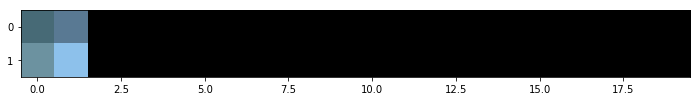

In [70]:
plt.figure(figsize=(12, 12))
plt.imshow(figure)
plt.show()


# Notes

* Did the last conv layer wrong (did a masking layer, when I should have done a 1x1 on each channel) -- actually might want to actually do a type B mask on last layer...
* Debug using single image, then grow it
* GPU small, so cut down problem to 20x20x3; discretize outputs to 16 levels for each channel (vs. 256)
* Found the tensorflow loss function the best, didn't have to duplicate softmax, then call keras, which then converts back to a probability
* Don't need an explicit dense layer on output because loss function takes care of it for me.  Just use output of 1x1 conv directly.


# 2019-04-02

* Put together a small network, testing on 2 images
* Loss decreases but goes to NaN very quickly:

                     loss
        0   355135.187500
        1   303480.437500
        2   232975.671875
        3   160819.125000
        4   108442.257812
        5    73411.578125
        6    50420.945312
        7    40021.398438
        8    37298.570312
        9             NaN
        10            NaN
        
* I suspect it's something to do with the loss function.  I tried using the extra dummy "where" clause that the PixelCNN++ implementation has, but it didn't really solve my problem
* Ideas:
    * Maybe it's due to the `logsumexp`?  Weird b/c I'm using the tf version, which should be more stable
    * Also check the inv_stddev -- maybe I should be doing something different here?
    * The PixelCNN++ implementation also has a numerically stable `log_prob_from_logits` function (which is used on the mixture weights), maybe I need that?  Oh that implementation directly calculates log(softmax(.)), whereas I just go to softmax.  I guess log(small number) could overflow pretty easily?

# 2019-04-03

* The NaNs from before were due to problems with the softmax.  Instead of using `activation='softmax'` on the last `Dense` layer from the network, I just use no activation (to generate 'logits') and then do the `log(softmax(x))` inside the loss function using a numerically stable `log(softmax(.))`.  See https://stackoverflow.com/questions/44081007/logsoftmax-stability
* It appears the loss is still high (43k ~= 14 bits/pixel) for some reason.  Still need to figure out if I just need more training or something like that.  Might be a bug in the network?
* Also my image generation is super slow (GPU is not bottlenecked, it's CPU), most likely because when I'm sampling pixels, I use heavy loops instead of numpy functionality, maybe fix it.


# 2019-04-04

* Found a bug, `x_m` output was using sigmoid instead of no activation, thus we could only make light coloured pixels
* Still have problems fitting, debugging the first pixel (0, 0, 0) and it's way off in terms of where the logistic distribution lands.
* Tried shrinking image down to 1x1x3 and 2x2x3 and reducing network to just first Pixel2D layer + output layer, still have trouble fitting.
    * When I just have 1x1x3 with a `relu` it doens't fit, but when I switch to `tanh` it fits?
    * However, when I grow to 2x2x3, it doesn't work anymore.
    * Very mysterious!
    * Looks like there is a bit of bias upwards, here is 2x3x3 with `tanh` on Pixel2D layer, you can see that we're biasing high for some reason...  Not exactly sure why
   
            ==== 0 0 0
            X_train[0, i, j, k] =  -0.5372549019607843  (59.0)
             m:  [-0.4418291  -0.10670283]
             E[m]:  -0.36888298
             invs:  [3.6220822 4.386565 ]
             weights:  [0.78233254 0.21766743]
             pvals:  61     0.010555
            62     0.013697
            63     0.017590
            64     0.022292
            65     0.027780
            66     0.033902
            67     0.040333
            68     0.046554
            69     0.051896
            70     0.055653
            71     0.057257
            72     0.056448
            73     0.053358
            74     0.048469
            75     0.042462
            76     0.036035
            77     0.029764
            78     0.024040
            79     0.019068
            80     0.014908
            81     0.011525
            110    0.010084
            111    0.016481
            112    0.024448
            113    0.031506
            114    0.033983
            115    0.030290
            116    0.022741
            117    0.014968
            dtype: float64
             pixel_val:  64
            ==== 0 0 1
            X_train[0, i, j, k] =  -0.5137254901960784  (62.0)
             m:  [-0.19672635 -0.04862855]
             E[m]:  -0.16470397
             invs:  [3.648991 4.455485]
             weights:  [0.7837754 0.2162246]
             pvals:  93     0.012366
            94     0.016080
            95     0.020649
            96     0.026096
            97     0.032321
            98     0.039046
            99     0.045774
            100    0.051809
            101    0.056360
            102    0.058726
            103    0.058507
            104    0.055744
            105    0.050895
            106    0.044694
            107    0.037928
            108    0.031267
            109    0.025174
            110    0.019905
            111    0.015550
            112    0.012107
            117    0.010143
            118    0.015054
            119    0.022677
            120    0.031315
            121    0.036671
            122    0.034908
            123    0.027123
            124    0.017923
            125    0.010622
            dtype: float64
             pixel_val:  104
            ==== 0 0 2
            X_train[0, i, j, k] =  -0.5058823529411764  (63.0)
             m:  [-0.08430319 -0.05333319]
             E[m]:  -0.07676396
             invs:  [3.7635202 4.4566603]
             weights:  [0.7565635  0.24343656]
             pvals:  108    0.012070
            109    0.016283
            110    0.021662
            111    0.028291
            112    0.036091
            113    0.044729
            114    0.053598
            115    0.061943
            116    0.069189
            117    0.075322
            118    0.080820
            119    0.085457
            120    0.086550
            121    0.080062
            122    0.065709
            123    0.048422
            124    0.033292
            125    0.022200
            126    0.014734
            dtype: float64
             pixel_val:  124
    
* Likely something wrong with `final_block` because when I add it, it moves everything to '0' pixels?